In [1]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import tldextract
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.data import HeteroData
from sklearn.preprocessing import LabelEncoder
from torch_geometric.datasets import MovieLens
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx,to_undirected
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import HANConv
import torch.nn.functional as F
from torch import nn

In [2]:
col_names_mentions = ["GlobalEventID","EventTimeDate","MentionTimeDate","MentionType",
        "MentionSourceName","MentionIdentifier","SentenceID","Actor1CharOffset","Actor2CharOffset",
        "ActionCharOffset","InRawText","Confidence","MentionDocLen","MentionDocTone",
        "SRCLC", "ENG"] # mention columns

col_names_events = ["GlobalEventID","Day","MonthYear","Year","FractionDate",
                            "Actor1Code","Actor1Name","Actor1CountryCode","Actor1KnownGroupCode","Actor1EthnicCode",
                            "Actor1Religion1Code","Actor1Religion2Code","Actor1Type1Code","Actor1Type2Code","Actor1Type3Code",
                            "Actor2Code","Actor2Name","Actor2CountryCode","Actor2KnownGroupCode","Actor2EthnicCode",
                            "Actor2Religion1Code","Actor2Religion2Code","Actor2Type1Code","Actor2Type2Code","Actor2Type3Code",
                            "IsRootEvent","EventCode","EventBaseCode","EventRootCode","QuadClass",
                            "GoldsteinScale","NumMentions","NumSources","NumArticles","AvgTone",
                            "Actor1Geo_Type","Actor1Geo_Fullname","Actor1Geo_CountryCode","Actor1Geo_ADM1Code","Actor1Geo_ADM2Code",
                            "Actor1Geo_Lat","Actor1Geo_Long","Actor1Geo_FeatureID","Actor2Geo_Type","Actor2Geo_Fullname",
                            "Actor2Geo_CountryCode","Actor2Geo_ADM1Code","Actor2Geo_ADM2Code","Actor2Geo_Lat","Actor2Geo_Long",
                            "Actor2Geo_FeatureID","ActionGeo_Type","ActionGeo_Fullname","ActionGeo_CountryCode","ActionGeo_ADM1Code",
                            "ActionGeo_ADM2Code","ActionGeo_Lat","ActionGeo_Long","ActionGeo_FeatureID","DATEADDED",
                            "SOURCEURL"] # event columns

with open("urls_to_download_fr.pkl", 'rb') as file: # label of articles (0 if fake or not present in MBFS)
    df_articles = pickle.load(file)
    
with open("labeled sources.pkl", 'rb') as file: # label of sources (0 if fake or not present in MBFS)
    df_sources = pickle.load(file)
    
with open("mixt_labeled_sources.pkl", 'rb') as file: # label of sources (nan if not present in MBFS)
    df_sources_mixte = pickle.load(file)
    
with open("mixt_labeled_articles.pkl", 'rb') as file: # label of articles (nan if not present in MBFS)
    df_articles_mixte = pickle.load(file)

MBFS = pd.read_csv("../mediabiasfactcheck/mediabiasfactcheck.csv")

df_test = pd.read_csv("gdelt_data/20231001000000.mentions.CSV", delimiter='\t', names=col_names_mentions)

df_test_event = pd.read_csv("gdelt_data_event/20231001000000.export.CSV", delimiter='\t', names=col_names_events)


In [42]:
test1 = pd.read_csv("gdelt_data/20231001024500.mentions.CSV", delimiter='\t', names=col_names_mentions)

In [43]:
test2 = pd.read_csv("gdelt_data/20231001040000.mentions.CSV", delimiter='\t', names=col_names_mentions)

In [44]:
pd.set_option('display.max_rows', 20)

In [47]:
test2

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,SRCLC,ENG
0,1130331452,20231001013000,20231001040000,1,dailytelegraph.com.au,https://www.dailytelegraph.com.au/news/breakin...,14,-1,1996,2007,0,60,2258,-1.639344,NaN,NaN
1,1130331453,20231001013000,20231001040000,1,dailytelegraph.com.au,https://www.dailytelegraph.com.au/news/breakin...,14,-1,1996,2080,0,60,2258,-1.639344,NaN,NaN
2,1130331454,20231001013000,20231001040000,1,dailytelegraph.com.au,https://www.dailytelegraph.com.au/news/breakin...,14,1996,-1,2007,0,60,2258,-1.639344,NaN,NaN
3,1130331453,20231001013000,20231001040000,1,dailytelegraph.com.au,https://www.dailytelegraph.com.au/news/breakin...,14,1996,-1,2080,0,60,2258,-1.639344,NaN,NaN
4,1130336581,20231001024500,20231001040000,1,menafn.com,https://menafn.com/1107170092/Esim-Technology-...,4,1416,1313,1369,1,100,1429,1.260504,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,1130342593,20231001040000,20231001040000,1,dailyrecord.co.uk,https://www.dailyrecord.co.uk/news/scottish-ne...,1,84,185,107,1,100,2298,1.044386,NaN,NaN
1990,1130342594,20231001040000,20231001040000,1,dailyrecord.co.uk,https://www.dailyrecord.co.uk/news/scottish-ne...,12,2893,2990,2940,1,100,3019,-1.559454,NaN,NaN
1991,1130342595,20231001040000,20231001040000,1,dailymail.co.uk,https://www.dailymail.co.uk/news/article-12580...,3,491,439,418,0,40,1253,-3.305785,NaN,NaN
1992,1130342596,20231001040000,20231001040000,1,dailymail.co.uk,https://www.dailymail.co.uk/news/article-12580...,3,493,569,418,1,60,1253,-3.305785,NaN,NaN


In [ ]:
["Actor1Code","Actor1Name","Actor1CountryCode","Actor1KnownGroupCode","Actor1EthnicCode",
"Actor1Religion1Code","Actor1Religion2Code","Actor1Type1Code","Actor1Type2Code","Actor1Type3Code",
"Actor2Code","Actor2Name","Actor2CountryCode","Actor2KnownGroupCode","Actor2EthnicCode",
"Actor2Religion1Code","Actor2Religion2Code","Actor2Type1Code","Actor2Type2Code","Actor2Type3Code",
"IsRootEvent","EventCode","EventBaseCode","EventRootCode","QuadClass",
"GoldsteinScale","NumMentions","NumSources","NumArticles","AvgTone",
"Actor1Geo_Type","Actor1Geo_Fullname","Actor1Geo_CountryCode","Actor1Geo_ADM1Code","Actor1Geo_ADM2Code",
"Actor1Geo_Lat","Actor1Geo_Long","Actor1Geo_FeatureID","Actor2Geo_Type","Actor2Geo_Fullname",
"Actor2Geo_CountryCode","Actor2Geo_ADM1Code","Actor2Geo_ADM2Code","Actor2Geo_Lat","Actor2Geo_Long",
"Actor2Geo_FeatureID","ActionGeo_Type","ActionGeo_Fullname","ActionGeo_CountryCode","ActionGeo_ADM1Code",
"ActionGeo_ADM2Code","ActionGeo_Lat","ActionGeo_Long","ActionGeo_FeatureID","DATEADDED",
"SOURCEURL"]

In [9]:
embedding = df_test_event[["Actor1Code","Actor1Name","Actor1CountryCode","Actor1KnownGroupCode","Actor1EthnicCode",
"Actor1Religion1Code","Actor1Religion2Code","Actor1Type1Code","Actor1Type2Code","Actor1Type3Code",
"Actor2Code","Actor2Name","Actor2CountryCode","Actor2KnownGroupCode","Actor2EthnicCode",
"Actor2Religion1Code","Actor2Religion2Code","Actor2Type1Code","Actor2Type2Code","Actor2Type3Code",
"EventCode","EventBaseCode","EventRootCode","QuadClass",
"GoldsteinScale","NumMentions","NumSources","NumArticles","AvgTone",
"Actor1Geo_Type","Actor1Geo_Fullname","Actor1Geo_CountryCode","Actor1Geo_ADM1Code","Actor1Geo_ADM2Code",
"Actor1Geo_Lat","Actor1Geo_Long","Actor1Geo_FeatureID","Actor2Geo_Type","Actor2Geo_Fullname",
"Actor2Geo_CountryCode","Actor2Geo_ADM1Code","Actor2Geo_ADM2Code","Actor2Geo_Lat","Actor2Geo_Long",
"Actor2Geo_FeatureID","ActionGeo_Type","ActionGeo_Fullname","ActionGeo_CountryCode","ActionGeo_ADM1Code",
"ActionGeo_ADM2Code","ActionGeo_Lat","ActionGeo_Long","ActionGeo_FeatureID"]]

In [14]:
df_test_event[["Actor1Geo_Type","Actor1Geo_Fullname","Actor1Geo_CountryCode","Actor1Geo_ADM1Code","Actor1Geo_ADM2Code",
"Actor1Geo_Lat","Actor1Geo_Long","Actor1Geo_FeatureID"]]

,Actor1Geo_Type,Actor1Geo_Fullname,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_ADM2Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID
0,1,Australia,AS,AS,NaN,-25.0000,135.00000,AS
1,4,"Kamloops, British Columbia, Canada",CA,CA02,12566,50.6667,-120.33300,-566975
2,2,"California, United States",US,USCA,NaN,36.1700,-119.74600,CA
3,4,"Berlin, Berlin, Germany",GM,GM16,16538,52.5167,13.40000,-1746443
4,3,"Chicago, Illinois, United States",US,USIL,IL031,41.8500,-87.65010,423587
...,...,...,...,...,...,...,...,...
1314,4,"Mopti, Mopti, Mali",ML,ML04,19399,14.4891,-4.19283,-1071966
1315,4,"Mopti, Mopti, Mali",ML,ML04,19399,14.4891,-4.19283,-1071966
1316,5,"Gauteng, Gauteng, South Africa",SF,SF06,77346,-26.0833,28.25000,204226
1317,5,"Gauteng, Gauteng, South Africa",SF,SF06,77346,-26.0833,28.25000,204226


In [13]:
df_test_event[["EventCode","EventBaseCode","EventRootCode"]]

,EventCode,EventBaseCode,EventRootCode
0,90,90,9
1,20,20,2
2,50,50,5
3,172,172,17
4,17,17,1
...,...,...,...
1314,12,12,1
1315,12,12,1
1316,20,20,2
1317,20,20,2


In [4]:
df_articles_mixte

,links,is_fake
0,https://www.adelaidenow.com.au/lifestyle/luxe-...,0.0
1,https://www.heraldsun.com.au/lifestyle/luxe-fo...,0.0
2,https://leaderpost.com:443/news/national/canad...,0.0
3,https://www.israelnationalnews.com/news/377689,0.0
4,https://chicago.suntimes.com/2023/9/30/2387876...,0.0
...,...,...
1932082,https://www.wlwt.com/article/jacob-lew-us-amba...,NaN
1932083,https://www.wbaltv.com/article/jacob-lew-us-am...,NaN
1932084,https://tampabaysmix.iheart.com/content/2023-1...,NaN
1932085,https://z94radio.iheart.com/content/2023-10-31...,NaN


In [8]:
pd.set_option('display.max_columns', None)

## Data Analysis

In [26]:
df_sources_mixte["is_fake"].value_counts(dropna = False) /len(df_sources_mixte["is_fake"])

is_fake
NaN    13300
0.0     1107
1.0       35
Name: count, dtype: int64

In [4]:
df_articles_mixte["is_fake"].value_counts(dropna = False)/len(df_articles_mixte["is_fake"])

is_fake
NaN    0.744008
0.0    0.248798
1.0    0.007194
Name: count, dtype: float64

In [27]:
MBFS.isna().mean()

url                    0.043817
name                   0.000269
image_pseudoscience    0.900000
image_factual          0.081720
image_conspiracy       0.908333
image_bias             0.149462
freedom_rank           0.593817
country                0.546237
dtype: float64

In [56]:
df_sources_mixte[df_sources_mixte["is_fake"] == 1.0].head()

,links,is_fake
15,infiniteunknown.net,1.0
54,sott.net,1.0
102,dailymail.co.uk,1.0
131,wordpress.com,1.0
163,oann.com,1.0


In [104]:
df_articles_mixte[df_articles_mixte["links"].str.contains("oann.com")]

,links,is_fake
341,https://www.oann.com/newsroom/death-toll-rises...,1.0
688,https://www.oann.com/newsroom/man-accused-of-k...,1.0
29234,https://www.oann.com/newsroom/dem-rep-jamaal-b...,1.0
29364,https://www.oann.com/newsroom/girl-9-disappear...,1.0
36554,https://www.oann.com/newsroom/breonna-taylors-...,1.0
...,...,...
1908385,https://www.oann.com/newsroom/israeli-military...,1.0
1908605,https://www.oann.com/business/us-seeks-to-bloc...,1.0
1925791,https://www.oann.com/newsroom/person-of-intere...,1.0
1926135,https://www.oann.com/newsroom/fbi-chief-christ...,1.0


In [97]:
MBFS = MBFS.dropna(subset=['url'])
MBFS[MBFS["url"].str.contains("oann.com")]


,url,name,image_pseudoscience,image_factual,image_conspiracy,image_bias,freedom_rank,country
468,https://www.oann.com,One America News Network (OAN),NaN,MBFCLow.png,NaN,right.?.?.?.png,NaN,NaN


In [3]:
csv_count = 0
total = 0
nan = 0

for root, _, filenames in os.walk("gdelt_data"):
    for filename in filenames:
        if filename.endswith(".CSV"):
            csv_count += 1
            temp = pd.read_csv(os.path.join(root, filename), delimiter='\t', names=col_names_mentions)
            nan += temp.isna().mean()
            total+=len(temp)

print("csv_count for mentions: "+str(csv_count))
print("total number of lines for mentions: "+str(total))
print("percentage of nan for each column: "+str(nan/csv_count))

csv_count for mentions: 2974
total number of lines for mentions: 14485980
percentage of nan for each column: GlobalEventID        0.000000e+00
EventTimeDate        0.000000e+00
MentionTimeDate      0.000000e+00
MentionType          0.000000e+00
MentionSourceName    8.460116e-07
MentionIdentifier    0.000000e+00
SentenceID           0.000000e+00
Actor1CharOffset     0.000000e+00
Actor2CharOffset     0.000000e+00
ActionCharOffset     0.000000e+00
InRawText            0.000000e+00
Confidence           0.000000e+00
MentionDocLen        0.000000e+00
MentionDocTone       0.000000e+00
SRCLC                1.000000e+00
ENG                  1.000000e+00
dtype: float64


In [43]:
csv_count = 0
total = 0
nan = 0

for root, _, filenames in os.walk("gdelt_data_event"):
    for filename in filenames:
        if filename.endswith(".CSV"):
            csv_count += 1
            temp = pd.read_csv(os.path.join(root, filename), delimiter='\t', names=col_names_events) 
            total+=len(temp)
            nan += temp.isna().mean()


print("csv_count for events: "+str(csv_count))
print("total number of lines for events: "+str(total))
print("percentage of nan for each column: "+str(nan/csv_count))

csv_count for events: 2974
total number of lines for events: 4606957
percentage of nan for each column: GlobalEventID          0.000000
Day                    0.000000
MonthYear              0.000000
Year                   0.000000
FractionDate           0.000000
                         ...   
ActionGeo_Lat          0.024224
ActionGeo_Long         0.024117
ActionGeo_FeatureID    0.023964
DATEADDED              0.000000
SOURCEURL              0.000000
Length: 61, dtype: float64


In [4]:
value_count = 0
csv_count = 0

for root, _, filenames in os.walk("gdelt_data"):
    for filename in filenames:
        if filename.endswith(".CSV"):
            csv_count += 1
            temp = pd.read_csv(os.path.join(root, filename), delimiter='\t', names=col_names_mentions)
            value_count += temp["MentionType"].value_counts()
            if len(temp["MentionType"].value_counts())>1:
                print("omg")

            
print(value_count)


MentionType
1    14485980
Name: count, dtype: int64


## PreProcessing -> put in graph format

#### Creating Graph

In [4]:
from SimplePreprocessing import SimplePreprocessing

label = "source"
list_mention = ["gdelt_data/20231001000000.mentions.CSV"]
list_event = ["gdelt_data_event/20231001000000.export.CSV"]

preprocessing = SimplePreprocessing(label)
labels,df_events,df_mentions = preprocessing.data_load(list_event,list_mention)

In [5]:
from itertools import product

label_encoder_source = LabelEncoder()
labels['links'] = label_encoder_source.fit_transform(labels['links'])
label_mapping_source = dict(zip(label_encoder_source.classes_, label_encoder_source.transform(label_encoder_source.classes_)))
labels_sorted = labels.sort_values(by="links").set_index("links")
labels_sorted = labels_sorted.reset_index(drop=False)
mapping_source = labels_sorted["links"]
labels_sorted["random"] = np.random.rand(len(labels_sorted))
y = labels_sorted["is_fake"]#.apply(lambda x:int(x) if not pd.isna(x) else x )
labels_sorted = labels_sorted[["random"]]

df_article = pd.DataFrame(df_mentions["MentionIdentifier"])
label_encoder_article = LabelEncoder()
df_article['MentionIdentifier'] = label_encoder_article.fit_transform(df_article['MentionIdentifier'])
label_mapping_article = dict(zip(label_encoder_article.classes_, label_encoder_article.transform(label_encoder_article.classes_)))

df_article_sorted = df_article.sort_values(by="MentionIdentifier").set_index("MentionIdentifier")
df_article_sorted = df_article_sorted.reset_index(drop=False)
mapping_article = df_article_sorted["MentionIdentifier"]
df_article_sorted["random"] = np.random.rand(len(df_article_sorted))
df_article_sorted = df_article_sorted[["random"]]

label_encoder_event = LabelEncoder()
df_events['GlobalEventID'] = label_encoder_event.fit_transform(df_events['GlobalEventID'])
label_mapping_event = dict(zip(label_encoder_event.classes_, label_encoder_event.transform(label_encoder_event.classes_)))
# df_events['GlobalEventID'] = df_events['GlobalEventID'].map(label_mapping_event)
df_events_sorted = df_events.sort_values(by="GlobalEventID").set_index("GlobalEventID")
df_events_sorted = df_events_sorted.reset_index(drop=False)
mapping_event = df_events_sorted["GlobalEventID"]
df_events_sorted = df_events_sorted.drop("GlobalEventID",axis = 1)

df_mentions['MentionIdentifier'] = df_mentions['MentionIdentifier'].map(label_mapping_article)
df_mentions['MentionSourceName'] = df_mentions['MentionSourceName'].map(label_mapping_source)
df_mentions['GlobalEventID'] = df_mentions['GlobalEventID'].map(label_mapping_event)

df_mentions = df_mentions.dropna(subset = ["GlobalEventID"]) # because we encoded on events -> try to change that

est_source_de = df_mentions[["MentionSourceName","MentionIdentifier"]]

article_map = mapping_article.reset_index().set_index("MentionIdentifier").to_dict()
est_source_de["MentionIdentifier"] = est_source_de["MentionIdentifier"].map(article_map["index"]).astype(int)

source_map = mapping_source.reset_index().set_index("links").to_dict()
est_source_de["MentionSourceName"] = est_source_de["MentionSourceName"].map(source_map["index"]).astype(int)

edge_est_source_de = est_source_de[["MentionSourceName", "MentionIdentifier"]].values.transpose()

# Mapping articles and events to create edges between these two

mentionné = df_mentions[["GlobalEventID","MentionIdentifier"]]

article_map = mapping_article.reset_index().set_index("MentionIdentifier").to_dict()
mentionné["MentionIdentifier"] = mentionné["MentionIdentifier"].map(article_map["index"]).astype(int)

event_map = mapping_source.reset_index().set_index("links").to_dict()
mentionné["GlobalEventID"] = mentionné["GlobalEventID"].map(event_map["index"]).astype(int)

edge_mentionné = mentionné[["GlobalEventID", "MentionIdentifier"]].values.transpose()

same_actions = df_events[["GlobalEventID","EventCode"]]
edge_same_event = torch.tensor([], dtype=torch.long)
while len(same_actions) > 0:
    print(len(same_actions))
    same_action_nodes = (same_actions["EventCode"] == same_actions.iloc[0]["EventCode"])#.nonzero().squeeze()
    cartesian_product = list(product(same_actions[same_action_nodes]['GlobalEventID'], repeat=2))
    edges = [[x, y] for x, y in cartesian_product if x != y and cartesian_product.index((x, y)) < cartesian_product.index((y, x))]
    edges_t = torch.tensor(list(zip(*edges)))
    edge_same_event = torch.cat((edge_same_event, edges_t), dim=1)
    same_actions = same_actions.drop(same_actions[same_action_nodes].index)
edge_same_event_0 = list(pd.DataFrame(edge_same_event).loc[0].map(event_map["index"]).astype(int))
edge_same_event_1 = list(pd.DataFrame(edge_same_event).loc[1].map(event_map["index"]).astype(int))
# print(edge_same_event_1)
edge_same_event = torch.tensor([edge_same_event_0,edge_same_event_1])
# print(edge_same_event) 

# Create attributes for the mentionné edges

df_mentions_edges = df_mentions.drop(["GlobalEventID","MentionIdentifier","MentionSourceName"], axis = 1)

# temporarily remove almost all columns for simplicity
df_events_sorted_temp = df_events_sorted[["Day"]] 
df_mentions_edges_temp = df_mentions_edges[["EventTimeDate"]]
labels_sorted_temp = labels_sorted.copy()
labels_sorted_temp["y"] = y

data = HeteroData()
data['article'].x = torch.from_numpy(df_article_sorted.to_numpy()).to(dtype=torch.float32)
data['source'].x = torch.from_numpy(labels_sorted_temp.to_numpy()).to(dtype=torch.float32)
# data['source'].y = y
data['event'].x = torch.from_numpy(df_events_sorted_temp.to_numpy()).to(dtype=torch.float32)


data['event', 'mentionne', 'article'].edge_attr = torch.from_numpy(df_mentions_edges_temp.to_numpy())

data['event', 'mentionne', 'article'].edge_index = torch.from_numpy(edge_mentionné).to(dtype=torch.long)
data['source', 'est_source_de', 'article'].edge_index = torch.from_numpy(edge_est_source_de).to(dtype=torch.long)

transform = T.RemoveIsolatedNodes()
data = transform(data)

data[label].y = pd.Series(data[label].x[:,1].numpy())
data[label].x = np.delete(data[label].x, 1, axis=1)

data_undirected = T.ToUndirected()(data)
data_undirected = data

num_labels = len(data_undirected[label].y)
known_indices = np.where(~data_undirected[label].y.isna())[0]
known_labels = data_undirected[label].y[known_indices]
train_labels, test_labels, train_idx, test_idx = train_test_split(known_labels, known_indices, test_size=0.2, random_state=42)
train_mask = torch.zeros(num_labels, dtype=torch.bool)
test_mask = torch.zeros(num_labels, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
data_undirected[label].train_mask = train_mask
data_undirected[label].test_mask = test_mask
data_undirected[label].y = torch.from_numpy(data_undirected[label].y.to_numpy())

C:\Users\matth\AppData\Local\Temp\ipykernel_6028\1800382023.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  est_source_de["MentionIdentifier"] = est_source_de["MentionIdentifier"].map(article_map["index"]).astype(int)
C:\Users\matth\AppData\Local\Temp\ipykernel_6028\1800382023.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  est_source_de["MentionSourceName"] = est_source_de["MentionSourceName"].map(source_map["index"]).astype(int)
C:\Users\matth\AppData\Local\Temp\ipykernel_6028\1800382023.py:54: 

1319
1296
1221
1212
1206
1194
1135
1018
1014
911
883
803
697
586
525
497
466
462
436
430
406
391
390
387
374
324
314
293
267
234
223
210
205
200
177
171
159
152
145
141
123
120
109
106
102
101
96
89
71
65
64
62
59
55
49
48
45
40
38
37
36
28
22
21
20
19
13
12
11
10
8
6
5
2
1


In [118]:
torch.from_numpy(edge_est_source_de).to(dtype=torch.long)

tensor([[ 461, 5199, 7027,  ..., 1432, 7312, 5872],
        [ 916, 1762,  580,  ..., 1117, 2410, 1908]])

In [119]:
same_event

tensor([[   0.,    0.,    0.,  ..., 2582., 2582., 2583.],
        [ 246.,  266.,  276.,  ..., 2583., 2584., 2584.]])

In [111]:
from itertools import product

same_actions = df_events[["GlobalEventID","EventCode"]]
num_nodes = len(df_events)
same_event = torch.tensor([], dtype=torch.long)

while len(same_actions)>0:
    print(len(same_actions))
    same_action_nodes = (same_actions["EventCode"] == same_actions.iloc[0]["EventCode"])#.nonzero().squeeze()
    cartesian_product = list(product(same_actions[same_action_nodes]['GlobalEventID'], repeat=2))
    edges = [[x, y] for x, y in cartesian_product if x != y and cartesian_product.index((x, y)) < cartesian_product.index((y, x))]
    edges_t = torch.tensor(list(zip(*edges)))
    same_event = torch.cat((same_event, edges_t), dim=1)
    same_actions = same_actions.drop(same_actions[same_action_nodes].index)

2674
2611
2444
2420
2396
2378
2286
2057
2041
1836
1783
1670
1442
1200
1089
1045
985
976
904
898
854
834
833
829
797
711
697
641
589
533
500
487
476
471
435
418
399
391
379
375
330
327
301
298
293
290
285
263
238
232
230
219
206
196
182
179
176
167
157
152
151
137
131
127
125
122
112
111
110
108
106
102
101
95
94
93
91
88
86
83
76
70
69
67
65
64
63
62
61
54
53
51
44
42
38
36
34
29
28
24
22
20
19
18
15
10
8
5
3


In [106]:
same_action_nodes

0       False
1        True
2       False
3       False
4       False
        ...  
2669    False
2670    False
2671    False
2672    False
2673    False
Name: EventCode, Length: 2674, dtype: bool

In [105]:
same_actions

,GlobalEventID,EventCode
0,0,90
1,1,20
2,2,50
3,3,172
4,4,17
...,...,...
2669,2669,10
2670,2670,51
2671,2671,141
2672,2672,120


In [104]:
same_actions.drop(same_actions[same_action_nodes].index)

,GlobalEventID,EventCode
0,0,90
2,2,50
3,3,172
4,4,17
5,5,71
...,...,...
2669,2669,10
2670,2670,51
2671,2671,141
2672,2672,120


In [28]:
df_article_sorted

,random
0,0.801010
1,0.711614
2,0.314719
3,0.655120
4,0.228278
...,...
1850,0.922829
1851,0.657584
1852,0.267706
1853,0.705429


#### Just to check that everything is going well

In [6]:
pd.Series(data_undirected["source"].y).value_counts(dropna = False)

NaN    96
0.0    46
1.0     4
Name: count, dtype: int64

In [224]:
data_undirected.has_isolated_nodes()

False

In [222]:
data_undirected.is_undirected()

True

In [221]:
data.has_self_loops()

False

In [25]:
data.num_nodes

1781

In [88]:
data.num_edges

3678

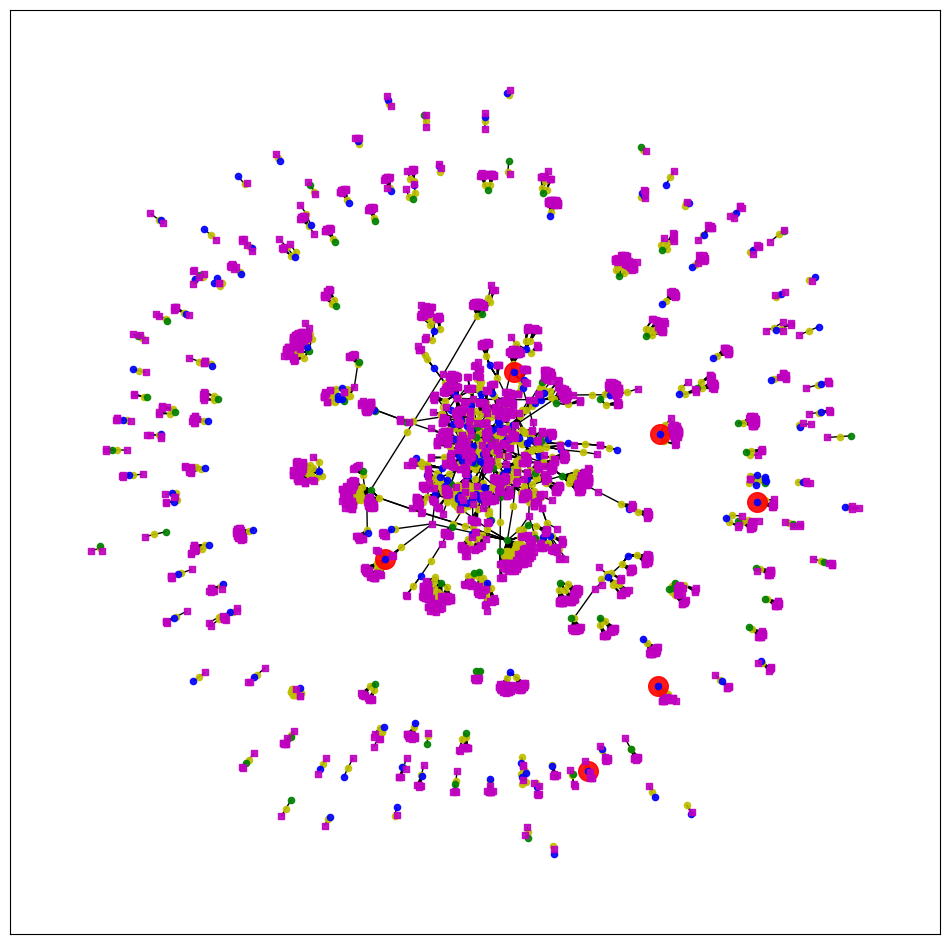

In [18]:
G = nx.MultiDiGraph()

ag_list = []
sgt_list = []
sgf_list = []
sgn_list = []
eg_list = []

for i, row in df_article_sorted.iterrows():
    G.add_node(f"{i}_a", node_type='article', x=row.to_numpy().astype(np.float32))
    ag_list.append(f"{i}_a")
for i, row in labels_sorted.iterrows():
    G.add_node(f"{i}_s", node_type='source', x=row.to_numpy().astype(np.float32))
    if y[i] == 1:
        sgf_list.append(f"{i}_s")
    if y[i] == 0:
        sgt_list.append(f"{i}_s")
    else:
        sgn_list.append(f"{i}_s")
for i, row in df_events_sorted_temp.iterrows():
    G.add_node(f"{i}_e", node_type='event', x=row.to_numpy().astype(np.float32))
    eg_list.append(f"{i}_e")

def append_suffix_mentionne(element, row_index):
    if row_index == 0:
        return str(element) + '_e'
    elif row_index == 1:
        return str(element) + '_a'
   
def append_suffix_edge_est_source_de(element, row_index):
    if row_index == 0:
        return str(element) + '_s'
    elif row_index == 1:
        return str(element) + '_a'
   
edge_mentionné_appended = np.vectorize(append_suffix_mentionne)(edge_mentionné, np.indices(edge_mentionné.shape)[0])
edge_est_source_de_appended = np.vectorize(append_suffix_edge_est_source_de)(edge_est_source_de, np.indices(edge_est_source_de.shape)[0])


G.add_edges_from(edge_mentionné_appended.transpose())
G.add_edges_from(edge_est_source_de_appended.transpose())

isolated_nodes = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(isolated_nodes)

G = G.to_undirected()

pos = nx.spring_layout(G)

plt.figure(figsize=(12,12))

nx.draw_networkx_edges(G, pos)

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in ag_list if x in G.nodes],
        node_size = 20,
        node_color = "y",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in sgf_list if x in G.nodes],
        node_size = 200,
        node_color = "r",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in sgt_list if x in G.nodes],
        node_size = 20,
        node_color = "g",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in sgn_list if x in G.nodes],
        node_size = 20,
        node_color = "b",
        node_shape = 'o',
        alpha=0.9,
       )

nx.draw_networkx_nodes(G,
        pos,
        nodelist = [x for x in eg_list if x in G.nodes],
        node_size = 20,
        node_color = 'm',
        node_shape = 's',
        alpha=0.9,
       )

plt.show()

### Creating a model

In [14]:
class HAN(torch.nn.Module):
    def __init__(self, in_channels: int=-1, hidden_channels: int=64,
              out_channels: int=2, n_heads=4, metadata=None):
        super(HAN, self).__init__()
        torch.manual_seed(12345)
        self.han_conv_0 = HANConv(in_channels,
                               hidden_channels,
                               heads=n_heads,
                               metadata=metadata,
                               dropout = 0.5)
        self.han_conv_1 = HANConv(hidden_channels,
                               hidden_channels,
                               heads=n_heads,
                               metadata=metadata,
                               dropout = 0.5)
        self.lin = nn.Linear(hidden_channels, out_channels)
 
    def forward(self, x_dict, edge_index_dict):
        
        x = self.han_conv_0(x_dict, edge_index_dict)
        # print(x)
        # x = x.relu()
        # x = self.han_conv_1(x, edge_index_dict)
        x = self.lin(x['source'])

        return x

In [15]:
model = HAN(metadata = data_undirected.metadata())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data_undirected.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['source'].train_mask
    # print(mask)
    # print(out)
    # print(data['source'].y[mask])
    loss = F.cross_entropy(out[mask], data['source'].y[mask].long())
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'test_mask']:
        mask = data['source'][split]
        acc = (pred[mask] == data['source'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

for epoch in range(0, 5):

    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 000, Loss: 0.9357, Train: 0.0750, Test: 0.1000
Epoch: 001, Loss: 0.8496, Train: 0.1500, Test: 0.1000
Epoch: 002, Loss: 0.7402, Train: 0.6500, Test: 0.7000
Epoch: 003, Loss: 0.6532, Train: 0.9250, Test: 0.9000
Epoch: 004, Loss: 0.5743, Train: 0.9250, Test: 0.9000


In [18]:
model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

### Creating another model

In [29]:

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear



class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)
    def forward(self, x_dict, edge_index_dict):
        
        for node_type, x in x_dict.items():
            # print(self.lin_dict[node_type].weight)
            # print(x)
            # print(self.lin_dict[node_type](x))
            x_dict[node_type] =  self.lin_dict[node_type](x).relu_()
        
        for conv in self.convs:
            print("hi2")
            # print(x_dict)
            # print(edge_index_dict)
            print(x_dict.keys())
            print(conv)
            x_dict = conv(x_dict, edge_index_dict)
        print(x_dict.keys())
        return self.lin(x_dict['source'])


model = HGT(hidden_channels=64, out_channels=2, num_heads=2, num_layers=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['source'].train_mask
    loss = F.cross_entropy(out[mask], data['source'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask','test_mask']:
        mask = data['source'][split]
        acc = (pred[mask] == data['source'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 11):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f' Test: {test_acc:.4f}')

hi2
dict_keys(['article', 'source', 'event'])
HGTConv(-1, 64, heads=2)
dict_keys(['article'])


KeyError: 'source'

In [95]:
import os.path as osp


import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import HGTConv, Linear


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
datatest = dataset[0]

Extracting data\mag\raw\mag.zip
Extracting data\mag\raw\mag_metapath2vec_emb.zip
Processing...
Done!


### Another one

In [136]:
from torch_geometric.nn import HEATConv
import torch
import torch.nn as nn

class HEAT(nn.Module):
    def __init__(self, in_channels,
                 out_channels: int, hidden_channels=16, heads=2, num_node_types = 3, num_edge_types = 2, edge_type_emb_dim = 1, edge_dim = 1, edge_attr_emb_dim = 1):
        super().__init__()
        self.heat_conv = HEATConv(in_channels, hidden_channels, heads=heads,dropout=0.6, metadata=data.metadata(),num_node_types=num_node_types, num_edge_types=num_edge_types, edge_type_emb_dim=edge_type_emb_dim, edge_dim=edge_dim, edge_attr_emb_dim=edge_attr_emb_dim)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict, node_types, edge_types):
        out = self.heat_conv(x_dict, edge_index_dict, edge_attr = edge_attr_dict, node_type = node_types, edge_type = edge_types)
        out = self.lin(out['source'])
        return out


model = HEAT(in_channels=-1, out_channels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict, data.node_types, data.edge_types)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict, data.node_types, data.edge_types)
    loss = F.cross_entropy(out, data['source'].y)
    loss.backward()
    optimizer.step()
    return float(loss)

AttributeError: 'dict' object has no attribute 'size'